###  1-Use the datasets library from Hugging Face to download the arabic- generated-abstracts dataset directly into a Python environment (By Google Colab).

In [ ]:
# !pip install datasets
# !pip install python-dotenv


In [1]:
from dotenv import load_dotenv
import os
from huggingface_hub import login

load_dotenv()

hf_token = os.getenv("HF_TOKEN")
login(token=hf_token)

In [2]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
dataset = load_dataset("KFUPM-JRCAI/arabic-generated-abstracts")
print(dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    by_polishing: Dataset({
        features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
        num_rows: 2851
    })
    from_title: Dataset({
        features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
        num_rows: 2963
    })
    from_title_and_content: Dataset({
        features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
        num_rows: 2574
    })
})


In [3]:
import pandas as pd
# Combine all splits into one df_human
splits = ["by_polishing", "from_title", "from_title_and_content"]

df_human = pd.concat([dataset[s].to_pandas() for s in splits], ignore_index=True)

In [4]:
dfs = []

for split_name in ["by_polishing", "from_title", "from_title_and_content"]:
    split_df = dataset[split_name].to_pandas().copy()
    split_df["source_split"] = split_name   # <-- Create column manually
    dfs.append(split_df)

df_human = pd.concat(dfs, ignore_index=True)

In [5]:
ai_rows = []

for _, row in df_human.iterrows():
    ai_models = [
        ("allam", row["allam_generated_abstract"]),
        ("jais", row["jais_generated_abstract"]),
        ("llama", row["llama_generated_abstract"]),
        ("openai", row["openai_generated_abstract"]),
    ]

    for model_name, text in ai_models:
        ai_rows.append({
            "abstract_text": text,
            "source_split": row["source_split"],     # now this exists
            "generated_by": model_name,
            "label": 0  # AI
        })

# Convert to dataframe
df_ai = pd.DataFrame(ai_rows)

# Create human dataframe
df_h = pd.DataFrame({
    "abstract_text": df_human["original_abstract"],
    "source_split": df_human["source_split"],
    "generated_by": "human",
    "label": 1
})

# Final unified dataset
df = pd.concat([df_h, df_ai], ignore_index=True)

print("Final unified dataset shape:", df.shape)
df.head(10)

Final unified dataset shape: (41940, 4)


,abstract_text,source_split,generated_by,label
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,by_polishing,human,1
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,by_polishing,human,1
2,شكلت تلك الجهود والمساعي الرائدة التي قام بها ...,by_polishing,human,1
3,يقوم المقال على اشكالية الضرائب الغير شرعية في...,by_polishing,human,1
4,تتفق المصادر التاريخية المتوفرة حول موضوع تطور...,by_polishing,human,1
5,تعددت صور الحياة الثقافية و الفكرية و الأدبية ...,by_polishing,human,1
6,تروم هذه المحاولة العلمية المتواضعة رصد ملامح ...,by_polishing,human,1
7,يعالج هذا المقال الإطار التنسيقي بين المنظمات ...,by_polishing,human,1
8,يتناول هذا المقال بالدرس، اقتصاد الأندلس المبن...,by_polishing,human,1
9,نعالج في هذا الموضوع المعنون ب«الثورة التحريري...,by_polishing,human,1


In [6]:
print(df.columns)

Index(['abstract_text', 'source_split', 'generated_by', 'label'], dtype='object')


###  Perform initial data exploration:

#### 1- Load and inspect the dataset structure (columns, data types).


In [7]:
# Inspect column names and data types for one split (e.g., 'by_polishing')
print("\nFeatures in 'by_polishing':")
print(dataset['by_polishing'].features)

# Check dataset info (shape, structure, statistics)
print("\nDataset info for 'by_polishing':")
print(dataset['by_polishing'])





Features in 'by_polishing':
{'original_abstract': Value('string'), 'allam_generated_abstract': Value('string'), 'jais_generated_abstract': Value('string'), 'llama_generated_abstract': Value('string'), 'openai_generated_abstract': Value('string')}

Dataset info for 'by_polishing':
Dataset({
    features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
    num_rows: 2851
})


#### 2- Check the distribution of the target variable (label: human vs. AI- generated)


In [8]:
num_human = df[df["label"] == 1].shape[0]
num_ai = df[df["label"] == 0].shape[0]

total = num_human + num_ai

print("\n===== Target Variable Distribution =====")
print("Human-written abstracts:", num_human)
print("AI-generated abstracts:", num_ai)
print("Human %:", round(num_human / total * 100, 2))
print("AI %:", round(num_ai / total * 100, 2))


===== Target Variable Distribution =====
Human-written abstracts: 8388
AI-generated abstracts: 33552
Human %: 20.0
AI %: 80.0


#### 3- Assess data quality: check for missing values, duplicates, and inconsistencies:


Missing values → any None/NaN in columns

Duplicates → same abstract appearing multiple times

Inconsistencies → like empty strings " " or unusual data

In [9]:
print("\n===== Missing Values =====")
print(df.isnull().sum())

print("\n===== Duplicate Rows =====")
print("Total duplicate rows:", df.duplicated().sum())

print("\n===== Duplicate values per column =====")
for col in df.columns:
    print(f"{col}: {df[col].duplicated().sum()}")

print("\n===== Empty / Blank Values =====")
for col in df.columns:
    empty_count = df[col].apply(lambda x: str(x).strip() == "").sum()
    print(f"{col}: {empty_count}")


===== Missing Values =====
abstract_text    0
source_split     0
generated_by     0
label            0
dtype: int64

===== Duplicate Rows =====
Total duplicate rows: 3

===== Duplicate values per column =====
abstract_text: 5415
source_split: 41937
generated_by: 41935
label: 41938

===== Empty / Blank Values =====
abstract_text: 0
source_split: 0
generated_by: 0
label: 0


# task 2.1: Arabic Text Preprocessing


In [10]:

import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from datasets import load_dataset


In [11]:
# Download required NLTK resources
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# Check columns
print(df.head())

                                       abstract_text  source_split  \
0  كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...  by_polishing   
1  يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...  by_polishing   
2  شكلت تلك الجهود والمساعي الرائدة التي قام بها ...  by_polishing   
3  يقوم المقال على اشكالية الضرائب الغير شرعية في...  by_polishing   
4  تتفق المصادر التاريخية المتوفرة حول موضوع تطور...  by_polishing   

  generated_by  label  
0        human      1  
1        human      1  
2        human      1  
3        human      1  
4        human      1  


In [13]:
#Define Arabic text cleaning functions
# Remove tashkeel (diacritics)
def remove_diacritics(text):
    arabic_diacritics = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    return re.sub(arabic_diacritics, '', text)

In [14]:
# Normalize Arabic text
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("[^؀-ۿ ]+", " ", text)  # remove non-Arabic chars
    return text

In [15]:
# Initialize stopwords and stemmer
arabic_stopwords = set(stopwords.words("arabic"))
stemmer = ISRIStemmer()

In [16]:
# Full preprocessing pipeline
def preprocess_text(text):
    text = str(text)
    text = remove_diacritics(text)
    text = normalize_arabic(text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in arabic_stopwords]
    tokens = [stemmer.stem(w) for w in tokens]
    return " ".join(tokens)

In [17]:
# Apply preprocessing
text_columns = [
    'abstract_text',
    'source_split',
    'generated_by',
    'label',
]

# Apply preprocessing on the unified abstract text column
df["abstract_text_clean"] = df["abstract_text"].apply(preprocess_text)

print("Preprocessing complete! Here are the new columns:")
print(df.columns)

df.head(2)

Preprocessing complete! Here are the new columns:
Index(['abstract_text', 'source_split', 'generated_by', 'label',
       'abstract_text_clean'],
      dtype='object')


,abstract_text,source_split,generated_by,label,abstract_text_clean
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,by_polishing,human,1,ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس حي...
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,by_polishing,human,1,يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي ...




## Features Engineering


In [18]:
#important library
import re
import math
import numpy as np
import pandas as pd
import unicodedata
from collections import Counter
from datasets import load_dataset
import regex as re2  # للاستخدام المتقدم (Arabic support)

In [19]:
#Helper functions


def simple_word_tokenize(text):
    """
    Tokenize text into words / symbols with Arabic support.
    """
    return re2.findall(r"\p{Arabic}+|\w+|[^\s\w]", text, flags=re2.VERSION1)

def sentence_tokenize(text):
    """
    Split text into sentences using Arabic/English punctuation.
    """
    if not isinstance(text, str):
        return []
    parts = re.split(r'(?<=[\.\?\!\u061F\u061B])\s+', text)
    return [p.strip() for p in parts if p.strip()]

def paragraph_tokenize(text):
    """
    Split text into paragraphs based on double newlines.
    """
    if not isinstance(text, str):
        return []
    paragraphs = re.split(r'\s*\n\s*\n\s*|\s*\r\n\s*\r\n\s*', text.strip())
    return [p.strip() for p in paragraphs if p.strip()]


In [20]:
# Column names to use
original_text_columns = "abstract_text"
clean_text_columns = "abstract_text_clean"


# 1. Tokens (use clean text)

df["tokens"] = df[clean_text_columns].apply(
    lambda t: [tok for tok in simple_word_tokenize(t) if tok.strip()] if isinstance(t, str) else []
)


# 2. Words (use clean tokens only)

df["words"] = df["tokens"].apply(
    lambda toks: [tok for tok in toks if re.search(r'\w', tok)]
)


# 3. Sentences (use original_text_columns for accurate sentence boundary detection)

df["sentences"] = df[original_text_columns].apply(
    lambda t: sentence_tokenize(t)
)


# 4. Paragraphs (use original_text_columns to preserve original structural breaks)

df["paragraphs"] = df[original_text_columns].apply(
    lambda t: paragraph_tokenize(t)
)

print("Feature engineering completed! Columns now:")
print(df.columns)
df.head(2)


Feature engineering completed! Columns now:
Index(['abstract_text', 'source_split', 'generated_by', 'label',
       'abstract_text_clean', 'tokens', 'words', 'sentences', 'paragraphs'],
      dtype='object')


,abstract_text,source_split,generated_by,label,abstract_text_clean,tokens,words,sentences,paragraphs
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,by_polishing,human,1,ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس حي...,"[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...","[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...",[كثيرا ما ارتبطت المصادر التاريخية في الأندلس ...,[كثيرا ما ارتبطت المصادر التاريخية في الأندلس ...
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,by_polishing,human,1,يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي ...,"[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...","[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...",[يعد العامل الثقافي احد ابرز الاسباب التي يعزى...,[يعد العامل الثقافي احد ابرز الاسباب التي يعزى...


In [21]:
# Column names to use
original_text_columns = "abstract_text"
clean_text_columns = "abstract_text_clean"


In [22]:
# Feature 2: Number of letters / C
import regex as _re

feature = f'{original_text_columns}_f002_letters_over_C'

def _ratio_letters(t):
    s = str(t) if pd.notna(t) else ""
    C = len(s)
    if C == 0:
        return 0.0
    letters = len(_re.findall(r'\p{L}', s, flags=_re.VERSION1))
    return letters / C

df[feature] = df[original_text_columns].apply(_ratio_letters)

In [23]:
# Feature 21: Brunet's W measure (approx)
#Brunet's W هو مقياس لتنوع المفردات في النص.
#قيمة W أقل → النص أكثر تنوعًا.
def _brunet_W(words, alpha=0.172):
    """Calculates Brunet's W measure of lexical diversity."""
    N = len(words) # Total tokens
    freq = Counter([w.lower() for w in words])
    V = len(freq) # Total types

    if N > 0 and V > 0:
        try:
            # W = N ^ (V ^ (-alpha))
            return N ** (V ** (-alpha))
        except OverflowError: # Handle potential large number errors gracefully
            return 0.0
    return 0.0

feature_name = f'{clean_text_columns}_f021_brunet_W'
df[feature_name] = df["words"].apply(_brunet_W)

In [24]:
# (40) Sentences length frequency distribution
df['f040_Sentence_length_frequency_distribution'] = df["sentences"].apply(
    # Assuming simple_word_tokenize is available
    lambda s: dict(Counter([len(simple_word_tokenize(sent)) for sent in s]))
    if s else {}
)

In [25]:
pip install pyarabic

In [26]:
import regex as _re          # better than "re" for Arabic letters
import pyarabic.araby as ar  # optional: Arabic normalization & letter handling

In [27]:
# HuggingFace tokenizer for embeddings
from transformers import AutoTokenizer
from collections import Counter

In [28]:
#59.Number of words found in the 500 positions within word  embedding (use corresponding word embedding aligned with the used LLM model)
#حساب أعلى 500 كلمة لكل مودل مسستخدم بالداتا


#  Load tokenizer (aligned to LLM)

model_name = "bert-base-uncased"   # change to your embedding model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Extract top 500 vocabulary tokens
top_500_vocab = set(list(tokenizer.get_vocab().keys())[:500])


#  Feature 3: Words found in top-500 embedding positions

feature = f"{clean_text_columns}_f059_words_in_top500"

def _count_words_in_top500(text):
    if text is None:
        return 0

    # Convert to string + normalize Arabic
    s = str(text)
    s = ar.normalize_hamza(s)             # normalize different hamza forms
    s = ar.normalize_ligature(s)          # normalize Arabic ligatures
    s = ar.strip_tashkeel(s)              # remove diacritics

    # split words on Arabic/English boundaries
    words = _re.findall(r"\p{L}+", s, flags=_re.VERSION1)

    # count matches with top 500 tokenizer words
    return sum(1 for w in words if w.lower() in top_500_vocab)

# Apply feature
df[feature] = df[clean_text_columns].apply(_count_words_in_top500)

In [29]:
df.head(5)

,abstract_text,source_split,generated_by,label,abstract_text_clean,tokens,words,sentences,paragraphs,abstract_text_f002_letters_over_C,abstract_text_clean_f021_brunet_W,f040_Sentence_length_frequency_distribution,abstract_text_clean_f059_words_in_top500
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,by_polishing,human,1,ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس حي...,"[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...","[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...",[كثيرا ما ارتبطت المصادر التاريخية في الأندلس ...,[كثيرا ما ارتبطت المصادر التاريخية في الأندلس ...,0.820477,9.013900,"{21: 1, 75: 1, 18: 1, 11: 1}",0
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,by_polishing,human,1,يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي ...,"[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...","[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...",[يعد العامل الثقافي احد ابرز الاسباب التي يعزى...,[يعد العامل الثقافي احد ابرز الاسباب التي يعزى...,0.820823,8.814629,{144: 1},0
2,شكلت تلك الجهود والمساعي الرائدة التي قام بها ...,by_polishing,human,1,شكل جهد سعي ريد قده ثور خلل رحل اول بحث صدر مو...,"[شكل, جهد, سعي, ريد, قده, ثور, خلل, رحل, اول, ...","[شكل, جهد, سعي, ريد, قده, ثور, خلل, رحل, اول, ...",[شكلت تلك الجهود والمساعي الرائدة التي قام بها...,[شكلت تلك الجهود والمساعي الرائدة التي قام بها...,0.809917,9.914172,"{81: 1, 22: 1, 94: 1, 42: 1}",0
3,يقوم المقال على اشكالية الضرائب الغير شرعية في...,by_polishing,human,1,يقم قال علي شكل ضريب غير شرع خلف رحل دول ربط و...,"[يقم, قال, علي, شكل, ضريب, غير, شرع, خلف, رحل,...","[يقم, قال, علي, شكل, ضريب, غير, شرع, خلف, رحل,...",[يقوم المقال على اشكالية الضرائب الغير شرعية ف...,[يقوم المقال على اشكالية الضرائب الغير شرعية ف...,0.819793,9.217091,"{26: 1, 59: 1, 38: 1}",0
4,تتفق المصادر التاريخية المتوفرة حول موضوع تطور...,by_polishing,human,1,تفق صدر ارخ توفر حول وضع تطر حرك وطن جزير نهي ...,"[تفق, صدر, ارخ, توفر, حول, وضع, تطر, حرك, وطن,...","[تفق, صدر, ارخ, توفر, حول, وضع, تطر, حرك, وطن,...",[تتفق المصادر التاريخية المتوفرة حول موضوع تطو...,[تتفق المصادر التاريخية المتوفرة حول موضوع تطو...,0.807692,8.529477,{151: 1},0


In [ ]:
#كود لازم لتطبيق الميزة 78
!pip install transformers torch


In [36]:
# Feature 78: Perplexity score (placeholder). Requires LM scoring. Set up transformers and compute if desired.
#ميزة تعتمد على LM scoring، أي استخدام نموذج لغة (مثل GPT أو أي نموذج من مكتبة Hugging Face transformers) لحساب perplexity للنصوص. الـ perplexity هو مقياس لمدى قدرة النموذج على التنبؤ بالنص: كلما كان الرقم أصغر، كان النص أكثر “تناسقًا” أو متوافقًا مع اللغة التي تعلم عليها النموذج.
#مكتبات لازمة
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
model_name_ppx = "aubmindlab/aragpt2-base"   # Arabic GPT2 model
tokenizer_ppx = AutoTokenizer.from_pretrained(model_name_ppx)
model_ppx = AutoModelForCausalLM.from_pretrained(model_name_ppx)
model_ppx.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ppx.to(device)

# Feature 78 name
feature_ppx = f"{clean_text_columns}_f078_perplexity"

def _calculate_perplexity_ar(text):
    text = str(text).strip()
    if not text:
        return None

    try:
        inputs = tokenizer_ppx(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=512
        )

        input_ids = inputs.input_ids.to(device)

        with torch.no_grad():
            outputs = model_ppx(input_ids, labels=input_ids)
            loss = outputs.loss

        return float(torch.exp(loss).cpu().item())

    except Exception:
        return None

  #Apply Feature 78 to the clean text column
df[feature_ppx] = df[clean_text_columns].apply(
    lambda t: _calculate_perplexity_ar(t) if pd.notna(t) else None
)





KeyboardInterrupt: 

#Split the data



In [30]:
from sklearn.model_selection import train_test_split

# First split: Train 70%, Temp 30%
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, shuffle=True)

# Second split: Temp 30% → 15% Validation, 15% Test
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, shuffle=True)

# Show sizes
print("TOTAL:", len(df))
print("TRAIN:", len(train_df))
print("VAL:", len(val_df))
print("TEST:", len(test_df))

TOTAL: 41940
TRAIN: 29358
VAL: 6291
TEST: 6291


#TF-IDF Features from Cleaned Text


In [31]:
#apply with abstract_text_clean only
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer for Arabic text
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,   # limit vocabulary
    ngram_range=(1,2),   # unigrams + bigrams
    analyzer='word'
)

# Fit only on training set
tfidf_vectorizer.fit(train_df["abstract_text_clean"])

# Transform train/validation/test sets
X_train_tfidf = tfidf_vectorizer.transform(train_df["abstract_text_clean"])
X_val_tfidf   = tfidf_vectorizer.transform(val_df["abstract_text_clean"])
X_test_tfidf  = tfidf_vectorizer.transform(test_df["abstract_text_clean"])

print("TF-IDF shapes:")
print("Train:", X_train_tfidf.shape)
print("Validation:", X_val_tfidf.shape)
print("Test:", X_test_tfidf.shape)

TF-IDF shapes:
Train: (29358, 5000)
Validation: (6291, 5000)
Test: (6291, 5000)


##Define X and y

In [32]:
from scipy.sparse import hstack


In [33]:
#Select numeric features (The generated feature engineering exclude label and text)
EXCLUDED_COLS = ['label', 'abstract_text', 'abstract_text_clean',
                 'tokens', 'words', 'sentences', 'paragraphs', 'abstract_text_pos_tags']
# Select columns that are numeric AND not in the exclusion list>>feature engineering columns
numeric_cols = [
    col for col in train_df.select_dtypes(include=np.number).columns.tolist()
    if col not in EXCLUDED_COLS
]
# Convert the numeric features DataFrames to NumPy arrays (dense matrices)
# We must use the values/to_numpy() method to extract the array for sparse matrix stacking.
X_train_num_array = train_df[numeric_cols].values
X_val_num_array   = val_df[numeric_cols].values
X_test_num_array  = test_df[numeric_cols].values


# Target variable
y_train = train_df["label"]
y_val   = val_df["label"]
y_test  = test_df["label"]

# Features: TF-IDF and the creating feature engineering
X_train = hstack([X_train_tfidf, X_train_num_array]).tocsr()
X_val= hstack([X_val_tfidf, X_val_num_array]).tocsr()
X_test= hstack([X_test_tfidf, X_test_num_array]).tocsr()

print("X and y are ready for ML models.")
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

X and y are ready for ML models.
Train: (29358, 5003) (29358,)
Validation: (6291, 5003) (6291,)
Test: (6291, 5003) (6291,)


#Build Machine learning Models

##1-Baseline Model (Naïve Bayes & Logistic Regression)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train on training set
lr_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = lr_model.predict(X_val)

# Evaluate on validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.9628040057224606

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4977
           1       0.94      0.88      0.91      1314

    accuracy                           0.96      6291
   macro avg       0.95      0.93      0.94      6291
weighted avg       0.96      0.96      0.96      6291



Test Accuracy: 0.9628040057224606

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4978
           1       0.93      0.89      0.91      1313

    accuracy                           0.96      6291
   macro avg       0.95      0.93      0.94      6291
weighted avg       0.96      0.96      0.96      6291



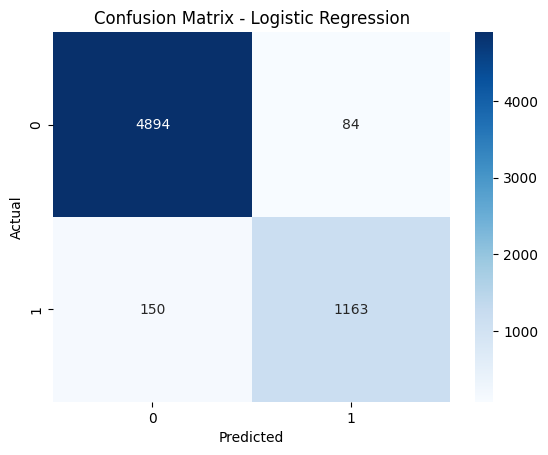

In [35]:
# Evaluation
# Predict on test set
y_test_pred = lr_model.predict(X_test)

# Evaluate on test set
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Optional: confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

##2-Traditional Machine Learning Models ( Support Vector Machine (SVM), Random Forest, XGBoost)using the validation set

In [38]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

# إذا كانت X_train sparse (مثل TF-IDF)، لا نستخدم StandardScaler مع with_mean=True
n_components = 300  # يمكن تعديلها
svd = TruncatedSVD(n_components=n_components, random_state=42)

svm_pipeline = Pipeline([
    ('svd', svd),
    ('svm', LinearSVC(C=1.0, max_iter=10000, random_state=42))
])

svm_pipeline.fit(X_train, y_train)
y_val_pred_svm = svm_pipeline.predict(X_val)

from sklearn.metrics import accuracy_score, classification_report
print("Linear SVM Validation Accuracy:", accuracy_score(y_val, y_val_pred_svm))
print(classification_report(y_val, y_val_pred_svm))


Linear SVM Validation Accuracy: 0.9432522651406772
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4977
           1       0.88      0.85      0.86      1314

    accuracy                           0.94      6291
   macro avg       0.92      0.91      0.91      6291
weighted avg       0.94      0.94      0.94      6291




===== LinearSVM Test Evaluation =====
Accuracy: 0.9429343506596726

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4978
           1       0.88      0.85      0.86      1313

    accuracy                           0.94      6291
   macro avg       0.92      0.91      0.91      6291
weighted avg       0.94      0.94      0.94      6291



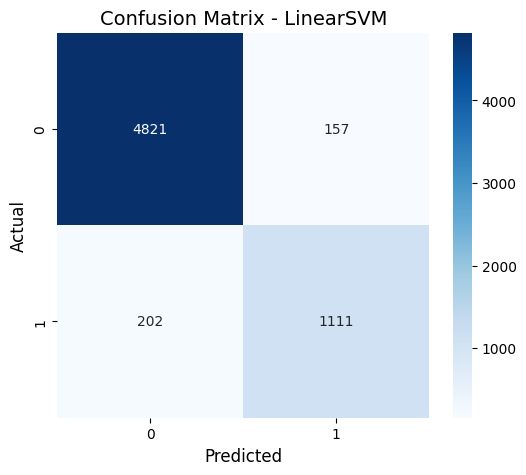


===== XGBoost Test Evaluation =====
Accuracy: 0.973931012557622

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4978
           1       0.93      0.95      0.94      1313

    accuracy                           0.97      6291
   macro avg       0.96      0.96      0.96      6291
weighted avg       0.97      0.97      0.97      6291



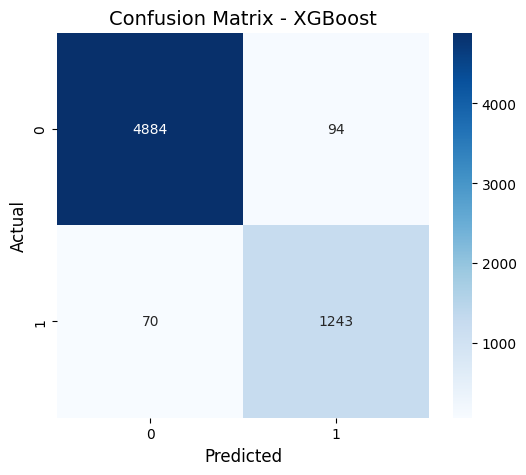

In [43]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# XGBoost محسّن للبيانات الكبيرة / sparse
xgb_model = xgb.XGBClassifier(
    n_estimators=200,      # عدد الأشجار
    max_depth=6,           # أقصى عمق لكل شجرة
    learning_rate=0.1,     # سرعة التعلم
    subsample=0.8,         # أخذ عينات من البيانات لتسريع التدريب وتجنب overfitting
    colsample_bytree=0.8,  # أخذ عينات من المميزات لكل شجرة
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,             # استخدام كل الأنوية المتاحة
    random_state=42
)

# تدريب النموذج
xgb_model.fit(X_train, y_train)

# التنبؤ والتحقق من الأداء
y_val_pred_xgb = xgb_model.predict(X_val)
print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))
print(classification_report(y_val, y_val_pred_xgb))


===== LinearSVM Test Evaluation =====
Accuracy: 0.9429343506596726

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4978
           1       0.88      0.85      0.86      1313

    accuracy                           0.94      6291
   macro avg       0.92      0.91      0.91      6291
weighted avg       0.94      0.94      0.94      6291



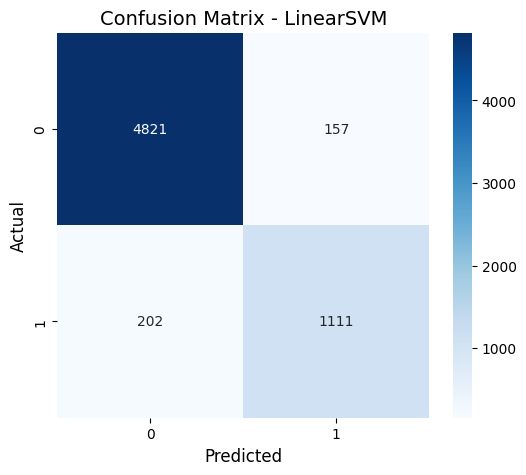


===== XGBoost Test Evaluation =====
Accuracy: 0.973931012557622

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4978
           1       0.93      0.95      0.94      1313

    accuracy                           0.97      6291
   macro avg       0.96      0.96      0.96      6291
weighted avg       0.97      0.97      0.97      6291



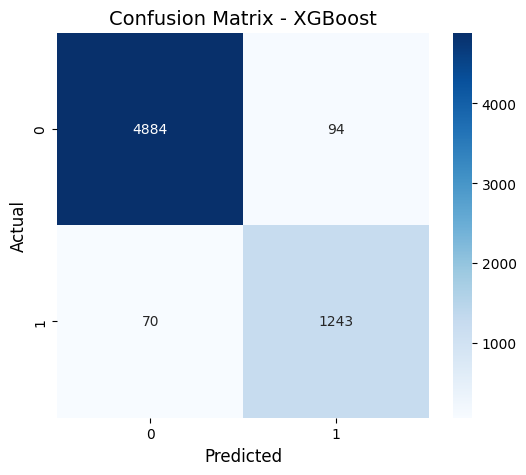

In [44]:
#Evaluation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# حفظ النماذج في قاموس لتسهيل التقييم
models = {
    'LinearSVM': svm_pipeline,
    'XGBoost': xgb_model
}

# تقييم كل نموذج على مجموعة الاختبار
for name, model in models.items():
    # التنبؤ على مجموعة الاختبار
    y_test_pred = model.predict(X_test)

    # طباعة النتائج
    print(f"\n===== {name} Test Evaluation =====")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # مصفوفة الالتباس
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=True, yticklabels=True)
    plt.title(f'Confusion Matrix - {name}', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.show()

#Build Deep learning Models

##Build neural network classifier ( simple Feedforward Network) on top of the extracted BERT embeddings or fine-tune the pre-trained BERT model for the classification task.

#Step1: Extract BERT Embeddings (Sentence-level)

In [ ]:
!pip install sentence-transformers


In [50]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import numpy as np

# ✅ اختيار الجهاز تلقائيًا (GPU إذا متاح، CPU إذا لا)
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running embeddings on:", device)

# تحميل نموذج صغير نسبيًا لتسريع الـ embeddings على CPU
bert_model = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    device=device
)

# الأعمدة المراد استبعادها
exclude_cols = ["label", "abstract_text"]

# دالة لدمج كل الأعمدة النصية المتبقية في عمود واحد
def combine_text_columns(df, exclude_cols):
    text_cols = [c for c in df.columns if c not in exclude_cols]
    combined_texts = df[text_cols].astype(str).agg(" ".join, axis=1).tolist()
    return combined_texts

# إعداد tokenizer لاختصار النصوص إذا كانت طويلة جدًا
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
max_tokens = 128  # عدد التوكن لكل نص لتسريع الحساب على CPU

def truncate_texts(texts, max_length=max_tokens):
    return [" ".join(tokenizer.tokenize(t)[:max_length]) for t in texts]

# --- تحضير البيانات ---
train_texts = truncate_texts(combine_text_columns(train_df, exclude_cols))
val_texts   = truncate_texts(combine_text_columns(val_df, exclude_cols))
test_texts  = truncate_texts(combine_text_columns(test_df, exclude_cols))

# --- دالة لتطبيق embeddings على دفعات لتسريع CPU ---
def encode_in_batches(texts, model, batch_size=128):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        emb = model.encode(batch, convert_to_numpy=True, show_progress_bar=False)
        embeddings.append(emb)
    return np.vstack(embeddings)

# --- إنشاء embeddings ---
X_train_emb = encode_in_batches(train_texts, bert_model, batch_size=128)
X_val_emb   = encode_in_batches(val_texts, bert_model, batch_size=128)
X_test_emb  = encode_in_batches(test_texts, bert_model, batch_size=128)

# --- المتغيرات المستهدفة ---
y_train = train_df["label"].values
y_val   = val_df["label"].values
y_test  = test_df["label"].values

# --- طباعة الأبعاد للتأكد ---
print("Train embedding shape:", X_train_emb.shape)
print("Validation embedding shape:", X_val_emb.shape)
print("Test embedding shape:", X_test_emb.shape)


Running embeddings on: cpu


Token indices sequence length is longer than the specified maximum sequence length for this model (2244 > 512). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: 

##Step 2: Build a Feedforward Neural Network

In [ ]:
#import tensorflow as tf
from tensorflow.keras import layers, models

# Basic feedforward classifier on embeddings
ffnn_model = models.Sequential([
    layers.Input(shape=(X_train_emb.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")   # binary classification
])

ffnn_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

ffnn_model.summary()

##Step3: Train the Model

In [ ]:
history = ffnn_model.fit(
    X_train_emb, y_train,
    validation_data=(X_val_emb, y_val),
    epochs=10,
    batch_size=32
)

##Step 4: Evaluate on Test Set

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Predict
y_test_pred = (ffnn_model.predict(X_test_emb) > 0.5).astype(int)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

##Save Models

In [51]:
import os
import joblib
from tensorflow.keras.models import Model as KerasModel

def save_all_models(models_dict, save_dir="models"):


    # Create save folder
    os.makedirs(save_dir, exist_ok=True)

    for model_name, model_obj in models_dict.items():


            file_path = os.path.join(save_dir, f"{model_name}.pkl")
            joblib.dump(model_obj, file_path)
            print(f"[Saved] Pickle model → {file_path}")

    print("\nAll models saved successfully!")

In [52]:
import os
os.makedirs("models", exist_ok=True)
models_dict = {
    "lr_model": lr_model,
    "svm": svm_pipeline,
    "xgboost": xgb_model,
    "ffnn": ffnn_model
}

save_all_models(models_dict)

[Saved] Pickle model → models/lr_model.pkl
[Saved] Pickle model → models/svm.pkl
[Saved] Pickle model → models/xgboost.pkl

All models saved successfully!
